In [10]:
import copy
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

In [11]:
# Create two datasets

def make_multiple_circles(radii, examples_per_ring, std=0.1,):
    """
    A dataset of concentric circles of alternating labels
    """
    assert type(radii) in [list, tuple, np.ndarray]

    X = np.zeros([0, 2])
    y = np.zeros([0,])

    for i, radius in enumerate(radii):
        # Rings alternate as labeled -1 or 1
        y_ = np.ones([examples_per_ring]) * (-1) ** i
        y = np.concatenate([y, y_], axis=0)

        # Create a ring of points with radii centered at radius
        #   but in any random angle from the origin
        r = radius + np.random.normal(0, std, examples_per_ring)
        theta = np.random.uniform(0, 2 * np.pi, examples_per_ring)

        # Convert (r, theta) coordinates to cartesian
        x0 = r * np.sin(theta)
        x1 = r * np.cos(theta)
        x_ = np.stack([x0, x1], axis=1)
        X = np.concatenate([X, x_], axis=0)

    return X, y.astype(int)


def make_spiral(n):
    """
    Yet another spiral dataset
    """
    y0 = np.zeros(n)
    y1 = np.ones(n)
    y = np.concatenate([y0, y1], axis=0).astype(int)
    z = np.concatenate(2 * [np.linspace(0, 4 * np.pi, n)], axis=0)

    x0 = z * np.sin(z + y * np.pi)
    x1 = z * np.cos(z + y * np.pi)
    X = np.stack([x0, x1], axis=1)

    y[y == 0] = -1

    return X, y


def numpy_to_tensor(lst):
    """
    Convert numpy array to torch tensor
    """
    if type(lst) == np.ndarray:
        return torch.tensor(lst).to(dtype=torch.float32)

    else:
        out = [torch.tensor(item).to(dtype=torch.float32) for item in lst]
        return tuple(out)

In [12]:
class HW1Net(torch.nn.Module):
    def __init__(self, layer_sizes=[], activation=torch.tanh):
        """
        Construct a simple neural network.

        Args:
         - layer_sizes: a list or tuple of hidden layer sizes. For example,
                        if layer_sizes = [4, 4], this will be a network
                        with linear layers with dimensions[2, 4], [4, 4], [4, 2]
         - activation:  a torch activation function
        """
        super().__init__()

        input_dims = (2, ) + tuple(layer_sizes)
        output_dims = tuple(layer_sizes) + (2, )
        dims = zip(input_dims, output_dims)

        self.activation = activation
        self.layers = []
        for i, (input_dim, output_dim) in enumerate(dims):
            # Create and initialize the layer
            layer = torch.nn.Linear(input_dim, output_dim)
            torch.nn.init.xavier_uniform_(layer.weight)
            self.layers.append(layer)

            # Register this layer so Pytorch tracks its parameters
            setattr(self, f"layer{i}", layer)

    def forward(self, x):
        n_layers = len(self.layers)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Activation on everything but the final layer
            if i + 1 < n_layers:
                x = self.activation(x)

        return x

In [13]:
def run_one_epoch(model, optimizer, X, y, train=True):

    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    output = model(X).squeeze()
    binary_targets = torch.where(y > 0, 1, 0)
    acc = torch.sum(torch.argmax(output, dim=1) == binary_targets) / y.size(0)
    loss = torch.nn.CrossEntropyLoss()(output, binary_targets)

    if train:
        loss.backward()
        optimizer.step()

    # Detach tells torch to stop tracking a tensor's gradients
    return acc.detach(), loss.detach()

In [14]:
def pretrain_and_train(pretrain_data, data, **kwargs):

    # Create the model and set up the optimizer
    model = HW1Net(
        layer_sizes=kwargs["layer_sizes"],
        activation=kwargs["activation"],
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs["learning_rate"])

    # Pretrain the model and save a copy of the pretrained model
    X, y = pretrain_data
    for _ in range(kwargs["n_pretrain_epochs"]):
        run_one_epoch(model, optimizer, X, y)
    pretrained_model = copy.deepcopy(model)

    # Train the model and track its performance over each epoch
    results = defaultdict(list)
    X_train, X_test, y_train, y_test = data
    for i in range(kwargs["n_train_epochs"]):
        train_acc, train_loss = run_one_epoch(
            model, optimizer, X_train, y_train)

        test_acc, test_loss = run_one_epoch(
            model, None, X_test, y_test, train=False)

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return pretrained_model, model, results

In [15]:
def make_prediction_function(model):
    """
    Our network outputs real-valued logits
    When we make final predictions, those should be +1 or -1
    """
    def predict(X):
        X = numpy_to_tensor(X)
        output = model(X).detach()
        binary_pred = np.argmax(output, axis=1)
        return np.where(binary_pred > 0, 1, -1)

    return predict


def plot_results(pretrained_model, trained_model,
                pretrain_data, data,
                results, title):
    """
    Given a (saved) pretrained model, our final trained model,
        the pretrained data, train and test data,
        and a dictionary of results,

    Build the six-panel figure that you'll use to show off your results.
    """
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12),
                             constrained_layout=True)

    X_pretrain, y_pretrain = pretrain_data
    X_train, X_test, y_train, y_test = data

    # Top right panel
    ax = axes[0, 1]
    ax.set_title("Pretrained Model on Train Data")
    plot_data(X_train, y_train, ax)
    predict = make_prediction_function(pretrained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Top left panel
    ax = axes[0, 0]
    ax.set_title("Pretrained Model on Pretrain Data")
    plot_data(X_pretrain, y_pretrain, ax)
    axes[0, 0].set_ylim(axes[0, 1].get_ylim())
    axes[0, 0].set_xlim(axes[0, 1].get_xlim())
    predict = make_prediction_function(pretrained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Middle left panel
    ax = axes[1, 0]
    ax.set_title("Trained Model on Train Data")
    plot_data(X_train, y_train, ax)
    predict = make_prediction_function(trained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Middle right panel
    ax = axes[1, 1]
    ax.set_title("Trained Model on Test Data")
    plot_data(X_test, y_test, ax)
    predict = make_prediction_function(trained_model)
    plot_decision_surface(predict, ax.axis(), ax=ax)

    # Bottom left
    ax = axes[2, 0]
    ax.set_title("Loss per Epoch")
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    n_epochs = len(train_loss)
    ax.plot(np.arange(n_epochs), train_loss, c='r', label='Train Loss')
    ax.plot(np.arange(n_epochs), test_loss, c='b', label='Test Loss')
    ax.legend(loc="best")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, 2 * ymax)

    # Bottom right
    ax = axes[2, 1]
    ax.set_title("Accuracy per Epoch")
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    n_epochs = len(train_acc)
    ax.plot(np.arange(n_epochs), train_acc, c='r', label='Train Acc')
    ax.plot(np.arange(n_epochs), test_acc, c='b', label='Test Acc')
    ax.legend(loc="best")
    ax.set_ylim(0, 1.1)

    final_accuracy = np.mean(test_acc[-10:])
    final_accuracy = f"Final Mean Test Accuracy: {100 * final_accuracy:.1f}%"
    ax.annotate(final_accuracy, xy=(0, 0.1),
                textcoords="data", fontsize=16)

    plt.suptitle(title, fontsize=24)
    plt.show()

In [16]:
def run_experiment(**kwargs):
    """
    Required kwargs:
    - title:                A name for this experiment

    - radii:                radii of rings in the multiple_circles dataset
    - examples_per_ring:    number of examples per ring

    - layer_sizes:          number of nodes per hidden layer in network
    - activation:           activation function for each hidden layer
    - learning_rate:        learning rate for SGD optimization
    - n_pretrain_epochs:    how many epochs to pretrain
    - n_train_epochs:       how many epochs to train
    """
    random.seed(1)
    np.random.seed(1)
    torch.manual_seed(1)

    pretrain_data = make_multiple_circles(
        radii=kwargs['radii'], examples_per_ring=kwargs['examples_per_ring']
    )
    pretrain_data = numpy_to_tensor(pretrain_data)

    # Do not change the number of spiral examples!
    spiral_data = make_spiral(32)
    spiral_data = numpy_to_tensor(train_test_split(*spiral_data, test_size=0.2, random_state=1))

    pretrained_model, trained_model, results = pretrain_and_train(
        pretrain_data, spiral_data, **kwargs)

    plot_results(pretrained_model, trained_model,
                 pretrain_data, spiral_data,
                 results, kwargs["title"])

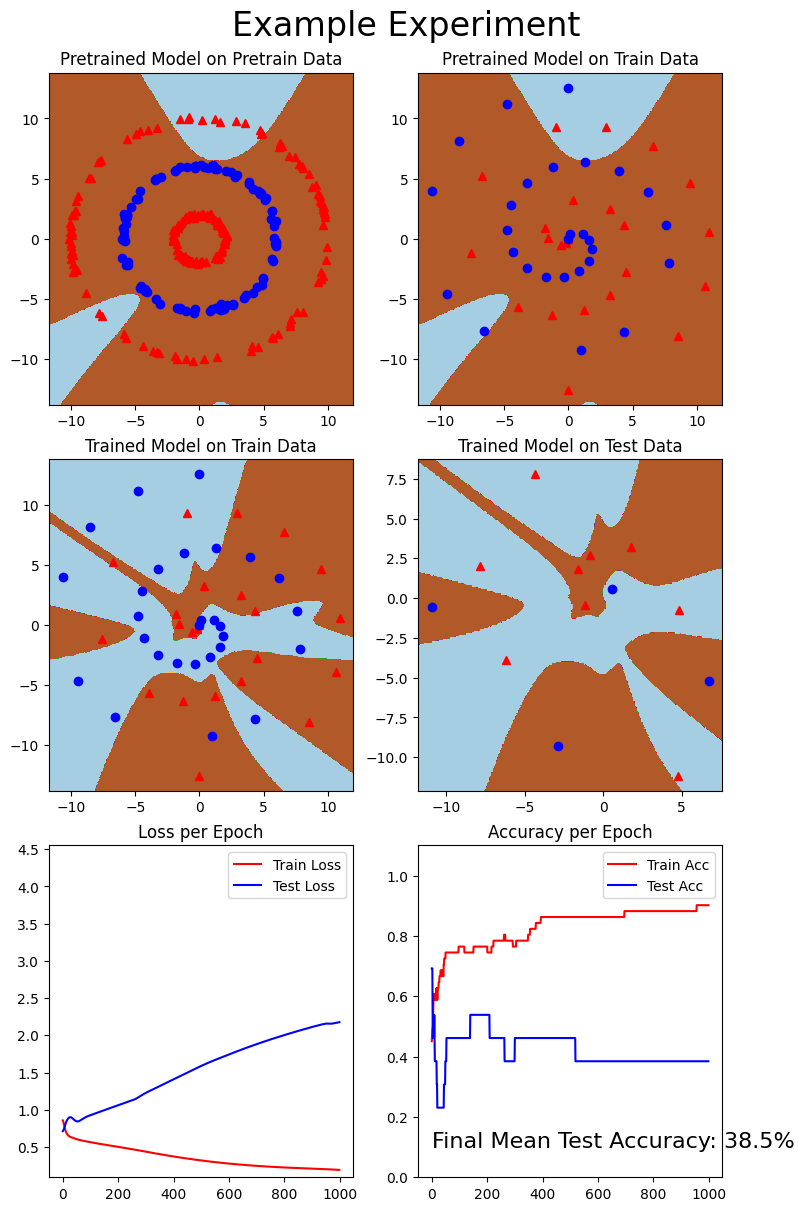

In [17]:
# Example experiment; you should copy this cell several times,
#   edit the kwargs, and save the figure outputs to your notebook.
kwargs = {
    "title": "Example Experiment",
    "radii": (2, 6, 10),
    "examples_per_ring": 100,
    "layer_sizes": [100, 10],
    "activation": torch.tanh,
    "learning_rate": 0.001,
    "n_pretrain_epochs": 100,
    "n_train_epochs": 1000,
}

run_experiment(**kwargs)